In [1]:
import os
import sys
import librosa
import tflearn
import tensorflow as tf
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


hdf5 not supported (please install/reinstall h5py)


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
os.chdir('/home/cc/Data/')
path = 'spoken_numbers_pcm/'

In [3]:
# Load a wav file
y, sr = librosa.load(path + '1_Junior_100.wav')
# Play it back!
IPython.display.Audio(data=y, rate=sr)

In [4]:
# mfcc - mel-frequency cepstral coefficients
mfcc = librosa.feature.mfcc(y=y, sr=sr)

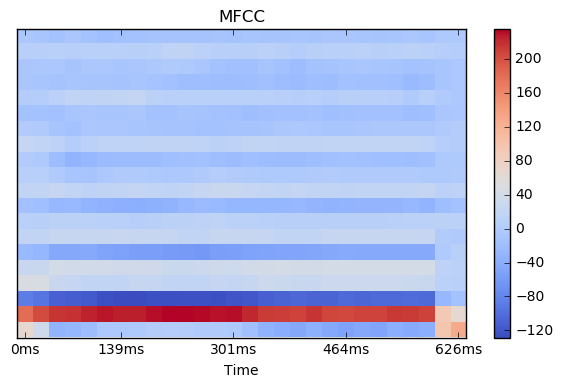

In [5]:
# visualize mfcc
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [6]:
# now for a spectrogram
m_spect = librosa.feature.melspectrogram(y=y, sr=sr)
# decompose a spectrogram with NMF, and then resynthesize an individual component
D = librosa.stft(y)

# Separate the magnitude and phase
S, phase = librosa.magphase(D)

# Decompose by nmf
components, activations = librosa.decompose.decompose(S, n_components=8, sort=True)

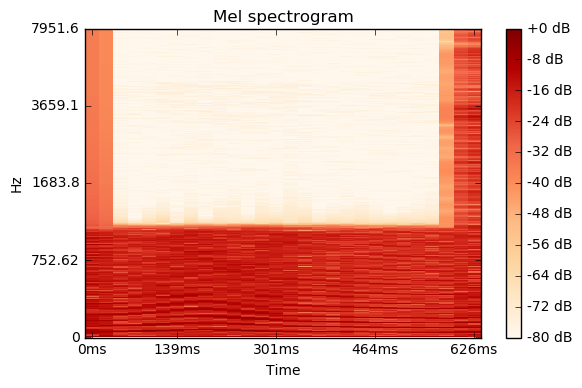

In [7]:
librosa.display.specshow(librosa.logamplitude(S, ref_power=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [4]:
def speaker(file):  # vom Dateinamen
  # if not "_" in file:
  #   return "Unknown"
  return file.split("_")[0]
def one_hot_from_item(item, items):
  # items=set(items) # assure uniqueness
  x=[0]*len(items)# numpy.zeros(len(items))
  i=items.index(item)
  x[i]=1
  return x
def get_speakers(path):
  files = os.listdir(path)
  def nobad(file):
    return "_" in file and not "." in file.split("_")[0]
  speakers=list(set(map(speaker,filter(nobad,files))))
  print(len(speakers)," speakers: ",speakers)
  return speakers

In [5]:
# now put all of the mfccs into an array
#os.chdir('/home/cc/Data/' + path)
os.chdir('/home/cc/Data/all/')
speakers = get_speakers(os.getcwd())
audio_files = os.listdir(os.getcwd())
mfccs = []
Y = []
for f in audio_files:
    Y.append(one_hot_from_item(speaker(f), speakers))
    y, sr = librosa.load(f)
    mfccs.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13))

(10, ' speakers: ', ['Speaker1', 'Speaker0', 'Speaker3', 'Speaker2', 'Speaker5', 'Speaker4', 'Speaker7', 'Speaker6', 'Speaker9', 'Speaker8'])


In [8]:
from pydub import AudioSegment as audio
waves = []
for f in audio_files:
    waves.append(audio.from_wav(f))
for f,w in zip(audio_files,waves):
    print(w.duration_seconds)

16.46
11.12
3.43
3.005
2.51
3.265
11.05
5.81
3.975
8.79
5.245
5.12
3.76
2.73
28.795
2.305
2.625
4.65
7.06
6.925
11.155
9.74
6.535
16.36
2.69
2.97
4.835
9.35
6.875
8.66
10.04
1.69
4.715
5.235
7.195
8.265
20.53
4.945
15.695
3.435
5.015
3.725
3.975
9.2799375
2.885
4.4049375
6.16
12.365
12.07
7.305
5.57
2.71
5.92
4.18
2.555
11.18
8.945
6.195
8.155
4.67
3.855
14.455
2.765
6.855
4.255
6.77
12.485
12.69
9.255
2.61
29.4
10.41
18.86
3.42
8.615
3.02
3.07
2.485
15.15
8.275
4.29
8.38
13.11
2.975
4.595
8.645
19.915
7.65
7.92
3.43
7.24
2.385
5.48
5.555
5.84
2.66
7.12
5.99
3.965
17.65
8.22
6.11
4.945
4.05
4.025
12.29
3.0100625
8.02
8.445
5.31
13.885
15.86
4.4
3.855
6.135
5.6
2.375
10.445
8.17
16.76
3.4
3.8
7.375
4.325
2.4449375
5.06
3.945
16.415
7.315
9.645
6.965
9.81
12.255
5.09
5.255
3.48
6.8
8.385
5.8
14.47
15.835
3.02
3.55
2.55
16.31
7.775
3.64
7.965
3.61
18.955
2.265
11.385
7.71
3.48
2.615
6.24
2.27
8.97
2.465
8.995
2.1
4.14
12.77
4.275
4.495
1.84
7.015
9.355
7.42
6.365
3.67
2.88
3.6
2.15
14.93


/usr/local/lib/python2.7/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
net = tflearn.input_data(shape=[None, 13, 22]) #Two wave chunks
net = tflearn.fully_connected(net, 64)
net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, 15, activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

In [5]:
model = tflearn.DNN(net)
model.fit(mfccs, Y, n_epoch=500, show_metric=True, snapshot_step=100)

Training Step: 6500  | total loss: 1.04569
| Adam | epoch: 500 | loss: 1.04569 - acc: 0.8317 -- iter: 809/809
Training Step: 6500  | total loss: 1.04569
| Adam | epoch: 500 | loss: 1.04569 - acc: 0.8317 -- iter: 809/809
--
